# KICKSTARTER CAMPAIGN SUCCESS PREDICTION

* Date Published: 2019/10/18
* Data Source: https://webrobots.io/kickstarter-datasets/

## Introduction 
Kickstarter is a US based global crowd funding platform focused on bringing funding to creative projects. Since the platform’s launch in 2009, the site has hosted over 159,000 successfully funded projects with over 15 million unique backers. Kickstarter uses an “all-or-nothing” funding system. This means that funds are only dispersed for projects that meet the original funding goal set by the creator.

### Project Objective
Kickstarter earns 5% commission on projects that are successfully funded. Currently, less than 40% of projects on the platform succeed. The objective is to predict which projects are likely to succeed so that these projects can be highlighted on the site either through 'staff picks' or 'featured product' lists.

### Proposed Solutions
Predict Successful Campaigns and promote those with the lowest predicted probability of being successful.
Contact creators from those campaigns that are just below the “success” margin and give them insights that could help them succeed.

In [1]:
import functools
import glob
import io
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import numpy as np
import os
import pandas as pd 
import seaborn as sns
import sys

import warnings
warnings.filterwarnings('ignore')

src_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

pd.set_option('display.max_columns', None)

from d02_processing.intermediate_cleaning import kickstarter_deduped_to_intermediate
from d02_processing.feature_engineering import kickstarter_feature_engineering
from d03_models.model_class import modelSelection
from d03_models.data_split import data_split

%load_ext autoreload

# reload modules so that as you change code in src, it gets loaded
%autoreload

## Exploratory Data Analysis

### Filter out Columns

**Here put the function used to deduplicate the original dataset. Also tell them what datasets you took originally from the website**

In [2]:
kick_deduped = pd.read_csv('../../data/02_intermediate/kick_deduped.csv.zip')

In [3]:
kick_inter = kickstarter_deduped_to_intermediate(kick_deduped)

In [4]:
print("Total number of Columns: ", len(kick_inter.columns))

Total number of Columns:  42


Our current dataset has 42 columns. We first need to narrow the columns down that we would like to work with. Since we are trying to predict whether or not a Kickstarter campaign will be successful or fail, we need to ensure that we are not using any features that contain "future information" (i.e. number of backers or amount pledged), because these features could be proxies for our target variable.

After taking a look through our data dictionary (located in the reference folder in the repository), we have identified 25 columns that we need to drop before building our model.

__**Columns to Drop:**__

1. **backers_count**: This is the number of people who backed the project. This column contains "future information" and could act as a proxy for our target variable.
1. **currency_symbol**: This feature is redundant with the currency feature.
1. **currency_trailing_code**: This feature is redundant with the currency feature.
1. **converted pledge amount**: This feature contains the amount of money that has been pledged to the campaign. This feature contains "future information" and could be used as a proxy for the target variable.
1. **current_currency**: This column is redundant with the currency column
1. **friends**: This column is 99% empty.
1. **ID**: Unique identifier for the campaign. Will need to be dropped before learning the model.
1. **Name**: Unique identifier for the campaign. Will need to be dropped before learning the model.
1. **is_backing**: This column is ~ 99% empty
1. **is_starrable**: This column contains "future information" regarding how successful Kickstarter believes the campaign will be.
1. **Permissions**: this column is 99% empty
1. **slug**: this column is redundant with name.
1. **source_url**: This is not needed for model building.
1. **spotlight**: This column contains "future information" regarding how successful Kickstarter believes the campaign will be.
1. **staff_pick**: This column contains "future information" regarding how successful Kickstarter believes the campaign will be.
1. **unread_message_count**: This column is empty.
1. **unseen_activity_count**: This column is empty.
1. **URL**: This is not needed for model building.
1. **usd_pleged**: Redundant with the currency column.
1. **country**: Redundant with the currency column (does not actually reflect where the campaign is.
1. **creator_name**: Unnecessary information.
1. **creator_slug**: Unnecessary information.
1. **disabled_communication**: False for all campaigns that have ended.
1. **last_update_published_at**: Column is empty.

In [5]:
kick_inter.drop(columns=['backers_count', 'converted_pledged_amount', 'country', 'currency_symbol', 
                         'currency_trailing_code', 'current_currency', 'disable_communication', 'friends', 
                         'is_backing', 'is_starrable', 'is_starred', 'last_update_published_at', 
                         'permissions', 'pledged', 'slug', 'source_url', 'spotlight', 'staff_pick', 
                         'static_usd_rate', 'unread_messages_count', 'unseen_activity_count', 
                         'urls', 'usd_pledged', 'usd_type'], 
                inplace=True)

Let's take a closer look at our 11 remaining columns: 

In [6]:
kick_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332899 entries, 0 to 332898
Data columns (total 18 columns):
blurb               332889 non-null object
created_at          332899 non-null datetime64[ns]
currency            332899 non-null object
deadline            332899 non-null datetime64[ns]
fx_rate             185035 non-null float64
goal                332899 non-null float64
id                  332899 non-null int64
launched_at         332899 non-null datetime64[ns]
name                332898 non-null object
state               332899 non-null object
state_changed_at    332899 non-null datetime64[ns]
sub_category        332899 non-null object
overall_category    332899 non-null object
city                331832 non-null object
country_loc         331832 non-null object
state_loc           331832 non-null object
creator_name        332899 non-null object
creator_slug        332899 non-null object
dtypes: datetime64[ns](4), float64(2), int64(1), object(11)
memory usage: 45.7+ MB

### Explore Remaining Columns

#### Created At

In [7]:
print('Earliest Kickstarter Campaign in the Dataset: ', kick_inter.created_at.min())
print('Latest Kickstarter Campaign in the Dataset: ', kick_inter.created_at.max())

Earliest Kickstarter Campaign in the Dataset:  2009-04-21 17:35:35
Latest Kickstarter Campaign in the Dataset:  2019-07-18 00:54:35


Average Number of Campaigns Launched Each Month:  2685.0


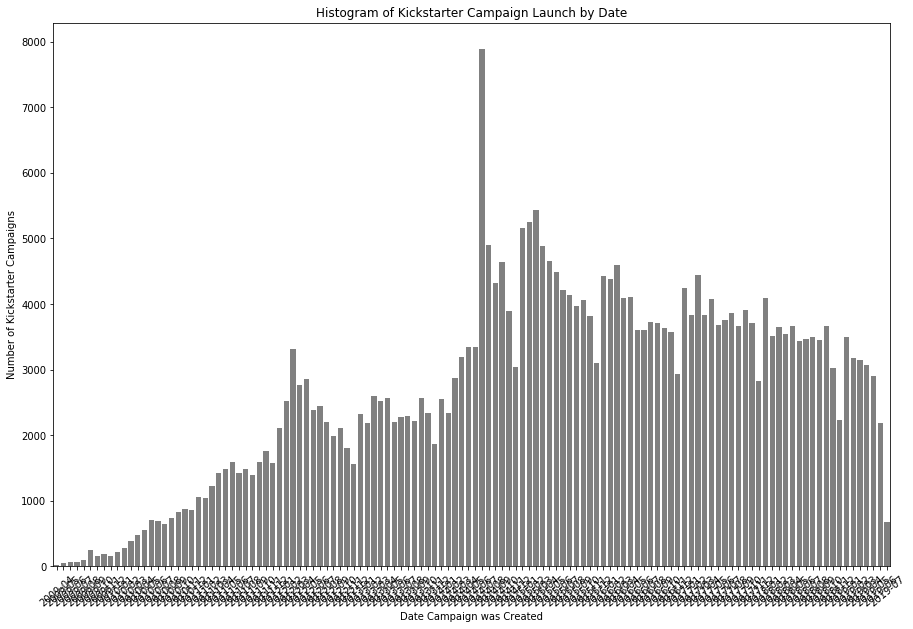

In [8]:
kick_inter['year_month'] = pd.to_datetime(kick_inter['created_at']).dt.to_period('M')
created_date_count = kick_inter.year_month.value_counts().to_frame().reset_index().\
    rename(columns={'index':'date', 'year_month': 'count'})

created_date_count.sort_values(by='date', inplace=True)

# average number of campaings launched each month
print('Average Number of Campaigns Launched Each Month: ', np.round(created_date_count['count'].mean()))

plt.figure(figsize=[15,10])
ax = sns.barplot(created_date_count['date'], created_date_count['count'], color='grey')
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=40)

# plt.locator_params(axis='x', nbins=10)
# ax.xaxis.set_major_locator(MultipleLocator(20))
plt.xlabel("Date Campaign was Created")
plt.ylabel("Number of Kickstarter Campaigns")
plt.title('Histogram of Kickstarter Campaign Launch by Date')

plt.show()

#### Goal & FX Rate

In [9]:
kick_inter['currency'].nunique()

14

The goal feature is in 14 different currencies (with USD and GBP as the most frequent). In order to build a model, we are going to have to convert all goal amounts to the same scale (USD) so that our model can interpret the feature correctly.

#### Overall category

Kickstarter campaigns fall into 1 of over 170 different overall categories and any number of 159 different sub-categories. The information both columns is repetitive. Since the sub-category has more specific information, I'd like to retain this category for further analysis.

In [10]:
kick_inter[['sub_category', 'overall_category']].head()

,sub_category,overall_category
0,Apparel,fashion/apparel
1,Tabletop Games,games/tabletop games
2,Fashion,fashion
3,Music,music
4,Drama,film & video/drama


In [11]:
print('Number of Categories in the "overall_category" column: ', kick_inter['overall_category'].nunique())

overallcat_group = kick_inter.groupby('overall_category')['deadline'].\
    count().reset_index().rename(columns={'deadline':'count'})

print('\n Top 10 Categories in overall_category column:')
overallcat_group.sort_values('count', ascending=False).head(5)

Number of Categories in the "overall_category" column:  170

 Top 10 Categories in overall_category column:


,overall_category,count
44,design/product design,18839
94,games/tabletop games,15431
95,games/video games,10717
135,publishing/fiction,8906
48,fashion/apparel,8881


In [12]:
mask_overall = (kick_inter['overall_category']=='games/tabletop games') |\
       (kick_inter['overall_category']=='design/product design') |\
       (kick_inter['overall_category']=='fashion/apparel') |\
       (kick_inter['overall_category']=='games/video games') |\
       (kick_inter['overall_category']=='publishing/fiction')

In [13]:
kick_inter.loc[mask_overall].groupby(['overall_category', 'state'])['overall_category'].count()

overall_category       state     
design/product design  live           8210
                       successful    10629
fashion/apparel        canceled        497
                       failed         5522
                       live            937
                       successful     1906
                       suspended        19
games/tabletop games   live           3752
                       successful    11679
games/video games      failed         4957
                       live           2862
                       successful     2898
publishing/fiction     failed         5071
                       live           1250
                       successful     2585
Name: overall_category, dtype: int64

### Location (city/ state/ country)

A location feature could be useful in predicting success of kickstarter campaigns. There are 211 countries represented in the dataset and over 12K cities. This column will need to be turned into a dummy variable for the models so city is too large. We will go with the country column for now and consider grouping this column into region).

In [14]:
print('Number of Countries that have produced a Kickstarter campaing: ', kick_inter.country_loc.nunique())
print('Number of Cities that have produced a Kickstarter Campaign: ', kick_inter.city.nunique())

Number of Countries that have produced a Kickstarter campaing:  211
Number of Cities that have produced a Kickstarter Campaign:  12685


## FEATURE CONSTRUCTION
After taking a look at the columns in our dataset, we have narrowed down the final list of features to train our models on.

Final Features

1. Blurb word count
1. Campaign length
1. Currency
1. Goal (converted to USD)
1. Delta between created_at and launched_at column
1. Sub category
1. Country
1. group cluster (KNN)
1. **state** [Target Variable]

In [15]:
kick_proc = kickstarter_feature_engineering(kick_inter)

In [16]:
kick_proc.head()

,currency,goal_original,id,category,overall_category,country,creator_name,creator_slug,year_month,blurb_word_count,campaign_length,delta_created_launched,goal_usd,successful_dummy,world_regions
0,USD,5000.0,1175125319,Tabletop Games,games/tabletop games,US,quEmpire Gaming,quempire,2019-06,9.0,32,13,5000.0,1,Northern America
1,USD,3500.0,920424993,Music,music,US,Drank The Gold,drankthegold,2019-06,14.0,18,1,3500.0,1,Northern America
2,USD,500.0,1253520992,Zines,publishing/zines,US,Zahira Chaudhry,,2019-07,17.0,15,1,500.0,1,Northern America
3,USD,6800.0,335137457,Graphic Novels,comics/graphic novels,US,Kirt Burdick,kirttrik,2019-06,12.0,30,6,6800.0,1,Northern America
4,USD,600.0,58084093,Mixed Media,art/mixed media,US,sassquire,sassquire,2019-06,19.0,30,0,600.0,1,Northern America


## Model Exploration & Tuning

In [17]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

It's now time to build our first model. Because we are making decisions about what campaigns to spotlight and contact for additional help, which will cost Kickstarter money and time, we want to go with a model that has the lowest number of false positives(i.e., the model with the lowest number of campaigns that are falsely identified as successful). Because of this, we will be maximizing our model for precision.

In [18]:
print('Number of Rows before dropping NAs: ', len(kick_proc))
kick_proc.dropna(inplace=True)
print('Number of Rows after dropping NAs: ', len(kick_proc))

Number of Rows before dropping NAs:  275651
Number of Rows after dropping NAs:  275642


In [19]:
X_feats = ['category', 'blurb_word_count', 'campaign_length', 
           'delta_created_launched', 'goal_usd','world_regions']

X, y = data_split(kick_proc, 'successful_dummy', X_feats)

Out outcome variable is also relatively balanced. We will not use any re-balancing techniques for now.

In [31]:
y.value_counts()

1    146584
0    129058
Name: successful_dummy, dtype: int64

### Baseline Model - Decision Tree

In [34]:
dtc = DecisionTreeClassifier(random_state=88)
dtc_selection = modelSelection(dtc, X, y)
dtc_selection.train_test_split_func()
dtc_selection.fit_func()
dtc_selection.predict_func()
dtc_selection.model_evaluation()

Acccuracy Score:  0.7026599526926035
Precision:  0.7218255711775043
Recall 0.7172952027506413


Confusion Matrix:
          predicted 0  predicted 1
actual 0        22135        10130
actual 1        10360        26286


### Bagging Model - Random Forest

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=88)

Parameter tuning

In [27]:
steps = [('rfc', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rfc__n_estimators':list(range(1, 200, 5)), 
             'rfc__criterion': ['gini', 'entropy'], 
             'rfc__max_depth': list(range(1, 10, 1)), 
             'rfc__min_samples_split': list(range(2, 10, 1)), 
             'rfc__min_samples_leaf': list(range(1, 5, 1))}

randomCV = RandomizedSearchCV(pipeline, parameters, cv=10)

randomCV.fit(X_train, y_train)

# best parameters that were chosen 
randomCV.best_params_

{'rfc__n_estimators': 166,
 'rfc__min_samples_split': 5,
 'rfc__min_samples_leaf': 2,
 'rfc__max_depth': 6,
 'rfc__criterion': 'entropy'}

In [32]:
rfc = RandomForestClassifier(n_estimators=166, min_samples_split=5, 
                             min_samples_leaf=2, max_depth=6, 
                             criterion='entropy', 
                            random_state=88)
rfc_selection = modelSelection(rfc, X, y)

In [33]:
dtc_selection.train_test_split_func()
dtc_selection.fit_func()
dtc_selection.predict_func()
dtc_selection.model_evaluation()

Acccuracy Score:  0.7026599526926035
Precision:  0.7218255711775043
Recall 0.7172952027506413


Confusion Matrix:
          predicted 0  predicted 1
actual 0        22135        10130
actual 1        10360        26286
